sources: https://stackoverflow.com/questions/61297312/finding-the-bounding-boxes-of-different-symbols-letters

https://github.com/OdyAsh/Handwritten-M2L/blob/main/model.ipynb

In [2]:
import numpy as np
import keras
from keras import layers
import cv2
import pickle
import os
import tensorflow as tf 

from matplotlib import pyplot as plt
from pygments.formatters import img

In [3]:

def find_bboxes_iter2(img, img_stages_flag=False):
    bboxes = []
    
    # store state of img after each stage
    img_stages = []
    
    #turn image into grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_stages.append(gray)
    
    #apply blur
    blur = cv2.GaussianBlur(gray, (7, 7), 0)
    img_stages.append(blur)
    
    #binarisation
    ret, binary_inv = cv2.threshold(blur, 150, 255, cv2.THRESH_BINARY_INV)
    img_stages.append(binary_inv)

    #dilation
    # kernel_dilate = np.ones((5, 5), np.uint8)
    kernel_dilate = cv2.getStructuringElement(cv2.MORPH_RECT, ksize=(2, 7))
    imgDilate = cv2.dilate(binary_inv, kernel_dilate, iterations=3)
    img_stages.append(imgDilate)

    
    #finding contours
    contours, _ = cv2.findContours(imgDilate, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    #find bboxes    
    for contour in contours:
        bbox = cv2.boundingRect(contour)
        bboxes.append(bbox)
            
    #draw bbox on img
    bbox_img = img.copy()
    for bbox in bboxes:
        x, y, w, h = bbox
        start_point = (x, y)
        end_point = (x + w, y + h)
        cv2.rectangle(bbox_img, start_point, end_point, (0, 255, 0), 2)
    
    img_stages.append(bbox_img) 
    
    if img_stages_flag:
        return bboxes, img_stages
    else: 
        return bboxes 





# Segmentation using bounding boxes


In [4]:
def find_bboxes_iter3(img):
    bboxes = []

    # store state of img after each stage
    img_stages = []
    
    #turn image into grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_stages.append(gray)
    
    #binarisation
    ret, binary_inv = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)
    img_stages.append(binary_inv)

    #dilation
    kernel_dilate = cv2.getStructuringElement(cv2.MORPH_RECT, ksize=(3, 8))
    imgDilate = cv2.dilate(binary_inv, kernel_dilate, iterations=3)
    img_stages.append(imgDilate)

    #finding contours
    contours, _ = cv2.findContours(imgDilate, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    #find bboxes    
    for contour in contours:
        bbox = cv2.boundingRect(contour)
        bboxes.append(bbox)
            
    #draw bbox on img
    bbox_img = img.copy()
    for bbox in bboxes:
        x, y, w, h = bbox
        start_point = (x, y)
        end_point = (x + w, y + h)
        cv2.rectangle(bbox_img, start_point, end_point, (0, 255, 0), 2)
    img_stages.append(bbox_img) 

    #order bboxes by x value
    bboxes = sorted(bboxes, key=lambda x: x[0])

    arrayLen = len(bboxes)
    noOverlapBBoxes = bboxes.copy()

    # iterate through all bounding box combinations 
    # improvement: use x coordinate and width and y coordinate and height 
    # to check for possible overlaps
    for i in range(arrayLen):
        for j in range(arrayLen):
            if j == i:
                pass
            else:
                IoA = IntersectionOverArea(bboxes[i], bboxes[j])
                if IoA > 0.8:
                    try:
                        noOverlapBBoxes.remove(bboxes[i])
                    except:
                        pass
    return noOverlapBBoxes



def removeBBoxOverlap(bboxes):
    arrayLen = len(bboxes)
    noOverlapBBoxes = bboxes.copy()


    # iterate through all bounding box combinations 
    # improvement: use x coordinate and width and y coordinate and height 
    # to check for possible overlaps
    for i in range(arrayLen):
        for j in range(arrayLen):
            if j == i:
                pass
            else:
                IoA = IntersectionOverArea(bboxes[i], bboxes[j])
                if IoA > 0.8:
                    try:
                        noOverlapBBoxes.remove(bboxes[i])
                    except:
                        pass
    return noOverlapBBoxes


def IntersectionOverArea(bbox1, bbox2):
    #finding top left and bottom right corner of first bbox
    x1, y1, w1, h1 = bbox1
    A1 = (x1, y1)
    B1 = (x1 + w1, y1 + h1)

    #finding top left and bottom right corner of the second bbox
    x2, y2, w2, h2 = bbox2
    A2 = (x2, y2)
    B2 = (x2 + w2, y2 + h2)

    # Intersection over Union
    # Area of intersection
    # _____________________ x
    # | 
    # |  A1
    # |
    # |
    # |      A2
    # |         B1
    # |
    # |                 B2
    # y

    # x determine the (x, y)-coordinates of the intersection rectangle
    xA = max(A1[0], A2[0])
    yA = max(A1[1], A2[1])
    xB = min(B1[0], B2[0])
    yB = min(B1[1], B2[1])

    # area of the intersection rectangle
    
    interArea = max(0, xB-xA+1) * max(0, yB-yA+1)

    # area of the first input box
    Area1 = (B1[0] - A1[0] +1)*(B1[1] - A1[1]+1)

    # area of intersection/area of box1
    IoA = interArea/float(Area1)
    return IoA





def visualiseBBoxes(img, bboxes, show_bbox_index=True):

    #draw bbox on img
    bbox_img = img.copy()

    for i, bbox in enumerate(bboxes):
        x, y, w, h = bbox
        start_point = (x, y)
        end_point = (x + w, y + h)
        cv2.rectangle(bbox_img, start_point, end_point, (0, 255, 0), 2)
        if show_bbox_index:
            cv2.putText(bbox_img, str(i), (start_point[0], start_point[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)
        else:
            pass

    return bbox_img



def load_equations(path):
    equation_imgs = []
    for fileName in os.listdir(path):
        
        img = cv2.imread(os.path.join(path, fileName), cv2.COLOR_BGR2GRAY)
        equation_imgs.append(img)
        
    return equation_imgs


def get_symbols(image, bboxes):

    symbols = []

    for bbox in bboxes:
        x, y, w, h = bbox
        symbol = image[y:y+h, x:x+w]
        symbol = cv2.cvtColor(symbol, cv2.COLOR_BGR2GRAY)
        symbol = cv2.resize(symbol, (45, 45), interpolation=cv2.INTER_AREA)
        symbol = symbol.reshape((45, 45, 1)) # adding extra dimension to fit model
        symbols.append(symbol)

    return symbols


        





## Plotting functions

In [5]:

def subplot(imgs):
    
    # Initialise the subplot function using number of rows and columns
    figure, axs = plt.subplots(3, 3)

    for i, image in enumerate(imgs):
        
        # calculating subplot location
        x_pos = (i)%3 
        y_pos = (i)//3

        # finding bbox positions and plotting them on input image
        bboxes = find_bboxes_iter3(image)
        bbox_img = visualiseBBoxes(image, bboxes)

        # plotting image
        axs[x_pos, y_pos].imshow(bbox_img)
        axs[x_pos, y_pos].axis('off')
        axs[x_pos, y_pos].set_title(i+1)

def subplot_stages(img):
    figure, axs = plt.subplots(3, 3)

    _, img_stages = find_bboxes_iter3(img)
    for i in range(9):
        x_pos = (i)%3 
        y_pos = (i)//3

        try:
            axs[x_pos, y_pos].imshow(img_stages[i])
        except:
            pass
        axs[x_pos, y_pos].axis('off')
        axs[x_pos, y_pos].set_title(i+1)

def oneplot(img):

    bboxes = find_bboxes_iter3(img)
    bbox_img = visualiseBBoxes(img, bboxes)

    plt.imshow(bbox_img)

def oneplot_stage(img, stage):
    _,  = find_bboxes_iter3(img)
    img_stage = img_stages[stage]

    plt.imshow(img_stage)
    



    



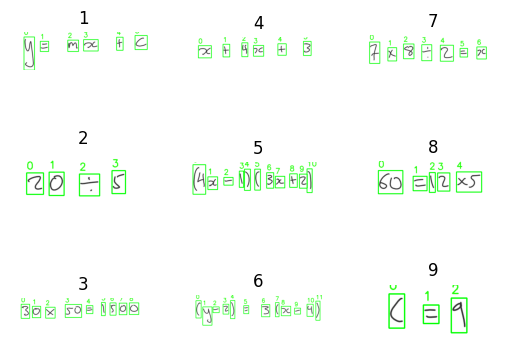

In [6]:
path = r"test_set1"
imgs = load_equations(path)



# stages 3 and 4

subplot(imgs)



In [27]:
# converts file name to latex

dic = {
    "-": r"-",
    "(": r"(",
    ")": r")",
    "+": r"+",
    "=": r"=",
    "times": r"\times",
    "0": r"0",
    "1": r"1",
    "2": r"2",
    "3": r"3",
    "4": r"4",
    "5": r"5",
    "6": r"6",
    "7": r"7",
    "8": r"8",
    "9": r"9",
    "div": r"\div", 
    "y": r"y", 
    "X": r"x", 
    "C": r"c", 
    "M": r"m"
}


dic_list = [v for k, v in dic.items()]
latexToNums = {k: v for v, k in enumerate(dic_list)}
numsToLatex = {v: k for v, k in enumerate(dic_list)}


In [ ]:
import cv2 
import numpy as np 
  
# Reading the input image 
img = cv2.imread('input.png', 0) 
  
# Taking a matrix of size 5 as the kernel 
kernel = np.ones((5, 5), np.uint8) 
  
# The first parameter is the original image, 
# kernel is the matrix with which image is 
# convolved and third parameter is the number 
# of iterations, which will determine how much 
# you want to erode/dilate a given image. 
img_erosion = cv2.erode(img, kernel, iterations=1) 
img_dilation = cv2.dilate(img, kernel, iterations=1) 
  
cv2.imshow('Input', img) 
cv2.imshow('Erosion', img_erosion) 
cv2.imshow('Dilation', img_dilation) 
  
cv2.waitKey(0) 

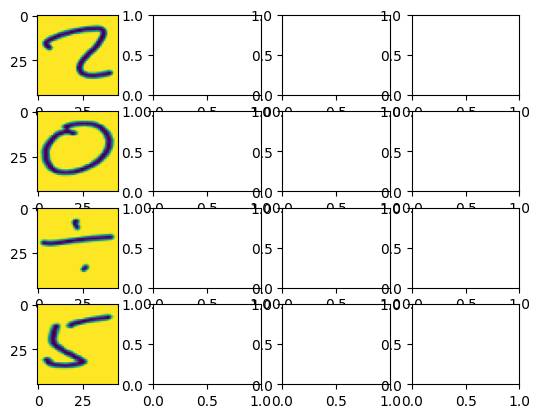

In [ ]:
test_img = imgs[1]
# find bounding boxes and crop out symbols
bboxes = find_bboxes_iter3(test_img)
bbox_img = visualiseBBoxes(test_img, bboxes)
symbols = get_symbols(test_img, bboxes)
np_symbols = np.array(symbols)




n=4
figure, axs = plt.subplots(n, n)

for i, symbol in enumerate(np_symbols):
    x_pos = i%n
    y_pos = i//n

    

    axs[x_pos, y_pos].imshow(symbol)



asdfsdfsdf



In [ ]:
model_path = r'models\test_set_1.keras'



# load model
model = keras.models.load_model(model_path, compile=True)

classified_symbols = []
for i in range(len(symbols)):
    symbol = np.array(symbols[i])
    y_pred = model.predict(tf.expand_dims(symbol, axis=0))
    symbol_class = numsToLatex[y_pred.argmax(axis=-1)[0]]
    classified_symbols.append(symbol_class)
    
print(classified_symbols)






TypeError: subplot() takes 1 or 3 positional arguments but 2 were given

<Figure size 640x480 with 0 Axes>

# Symbol recognition and latex translation

## create test dataset 1. No complex structures like intergrals and fractions. No superscripts or subscripts. 